<a href="https://colab.research.google.com/github/nnguyenu/ML-basic/blob/main/SM_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

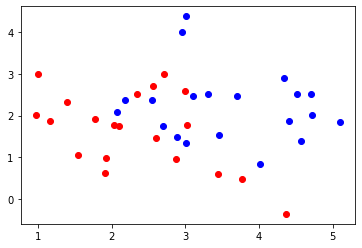

In [64]:
# generate data
# list of points 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
np.random.seed(22)
from matplotlib.backends.backend_pdf import PdfPages

means = [[2, 2], [4, 2]]
cov = [[.9, 0], [0, .9]]
N = 20
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)

plt.plot(X0[:,0],X0[:,1],'ro')
plt.plot(X1[:,0],X1[:,1],'bo')
#X1[-1, :] = [2.7, 2]
X = np.concatenate((X0, X1), axis = 0)
y = np.concatenate((np.ones((N, 1)), -1*np.ones((N, 1))), axis = 0).ravel()   # ravel() to change shape from (40,1) to (40,)

[[-1.09073673 -1.09449305]] 5.371245075196431


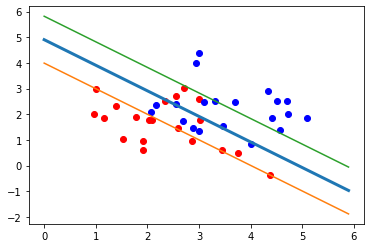

In [97]:
from sklearn.svm import SVC
C = 100
clf = SVC(kernel = 'linear', C = C)
clf.fit(X, y) 

w_sklearn = clf.coef_.reshape(-1, 1)
b_sklearn = clf.intercept_[0]
print(w_sklearn.T, b_sklearn)

plt.plot(X0[:,0],X0[:,1],'ro')
plt.plot(X1[:,0],X1[:,1],'bo')

# plot dividing line wx + b = 0
xx = np.arange(0,6,0.1)
yy = (-b_sklearn - w_sklearn[0,0]*xx) / w_sklearn[1,0]
plt.plot(xx,yy,linewidth = 3)

# plot margin line wx + b = 1
xx = np.arange(0,6,0.1)
yy = (1-b_sklearn - w_sklearn[0,0]*xx) / w_sklearn[1,0]
plt.plot(xx,yy)

# plot margin line wx + b = -1
xx = np.arange(0,6,0.1)
yy = (-1-b_sklearn - w_sklearn[0,0]*xx) / w_sklearn[1,0]
plt.plot(xx,yy)


In [76]:
from cvxopt import matrix, solvers
# build K
V = np.concatenate((X0.T, -X1.T), axis = 1)
K = matrix(V.T.dot(V))

p = matrix(-np.ones((2*N, 1)))
# build A, b, G, h 
G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N))))

h = matrix(np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1)))))
A = matrix(y.reshape((-1, 2*N))) 
b = matrix(np.zeros((1, 1))) 
solvers.options['show_progress'] = False
sol = solvers.qp(K, p, G, h, A, b)

l = np.array(sol['x'])
print('lambda = \n', l.T)

lambda = 
 [[2.78310611e-06 9.99999945e+01 2.86745352e-06 1.91442568e-05
  9.99999117e+01 1.58572755e-05 9.99999965e+01 6.23303276e+01
  9.99999974e+01 9.99997999e+01 9.99999836e+01 1.07966831e-05
  9.99999972e+01 9.99999947e+01 3.85694199e-06 6.01323637e+01
  1.05556008e-05 4.01942645e-06 2.05968959e-05 3.65768350e-06
  3.25327310e-06 3.56120600e-06 9.99999914e+01 9.99999962e+01
  9.99999967e+01 2.81113369e-06 2.24625177e+01 7.78437813e-06
  9.99999366e+01 9.99999943e+01 9.99999933e+01 2.59351981e-06
  9.99999972e+01 1.09546866e-05 2.78657571e-06 4.15381277e-06
  9.99999965e+01 3.23808235e-06 3.40790792e-06 9.99999967e+01]]


[[-1.09103902 -1.0946922 ]] 5.27649925554153


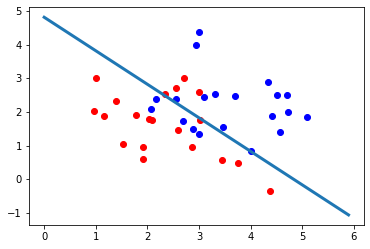

In [98]:
# support set 

# np.asarray(l > 1e-5): return boolean array where a[id] = True if l[id] > 1e-5 and False otherwise
# nonzero(): return the indices of the elements that are non-zero (see np.nonzero for more details)

S = np.where(l > 1e-5)[0]   # same as 'np.asarray(l>1e-5).nonzero()[0]'
S2 = np.where(l < .999*C)[0]  # same as 'np.asarray(l < .999*C).nonzero()[0]'
M = np.intersect1d(S,S2) # intersection of two lists

XT = X.T # we need each column to be one data point in this alg
VS = V[:, S]
lS = l[S]
yM = y[M]
XM = XT[:, M]

w_dual = VS.dot(lS).reshape(-1, 1)
b_dual = np.mean(yM.T - w_dual.T.dot(XM))
print(w_dual.T, b_dual) 

plt.plot(X0[:,0],X0[:,1],'ro')
plt.plot(X1[:,0],X1[:,1],'bo')

# plot dividing line wx + b = 0
xx = np.arange(0,6,0.1)
yy = (-b_dual - w_dual[0,0]*xx) / w_dual[1,0]
plt.plot(xx,yy,linewidth = 3)

In [102]:
X0_bar = np.vstack((X0.T, np.ones((1, N)))) # extended data
X1_bar = np.vstack((X1.T, np.ones((1, N)))) # extended data 

Z = np.hstack((X0_bar, - X1_bar)) # as in (22)
lam = 1./C

def cost(w):
    u = w.T.dot(Z) # as in (23)
    return (np.sum(np.maximum(0, 1 - u)) + .5*lam*np.sum(w*w)) - .5*lam*w[-1]*w[-1] # no bias 

def grad(w):
    u = w.T.dot(Z) # as in (23)
    H = np.where(u < 1)[1]
    ZS = Z[:, H]
    g = (-np.sum(ZS, axis = 1, keepdims = True) + lam*w)
    g[-1] -= lam*w[-1] # no weight decay on bias
    return g

eps = 1e-6
def num_grad(w):
    g = np.zeros_like(w)
    for i in range(len(w)):
        wp = w.copy()
        wm = w.copy()
        wp[i] += eps 
        wm[i] -= eps 
        g[i] = (cost(wp) - cost(wm))/(2*eps)
    return g 

w0 = np.random.randn(X0_bar.shape[0], 1) 
g1 = grad(w0)
g2 = num_grad(w0)
diff = np.linalg.norm(g1 - g2)
print('Gradient different: %f' %diff)

Gradient different: 0.000000


iter 1 cost: 91.994252
iter 10001 cost: 18.446965
iter 20001 cost: 18.458197
iter 30001 cost: 18.441320
iter 40001 cost: 18.447195
iter 50001 cost: 18.445234
iter 60001 cost: 18.439742
iter 70001 cost: 18.443055
iter 80001 cost: 18.443226
iter 90001 cost: 18.446123
[[-1.09205332 -1.09674562]] [5.38146076]


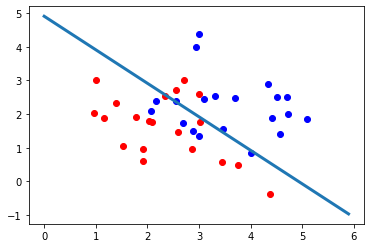

In [105]:
def grad_descent(w0, eta):
    w = w0
    it = 0 
    while it < 100000:
        it = it + 1
        g = grad(w)
        w -= eta*g
        if (it % 10000) == 1:
            print('iter %d' %it + ' cost: %f' %cost(w))
        if np.linalg.norm(g) < 1e-5:
            break 
    return w 
w0 = np.random.randn(X0_bar.shape[0], 1) 
w = grad_descent(w0, 0.001)
w_hinge = w[:-1].reshape(-1, 1)
b_hinge = w[-1]
print(w_hinge.T, b_hinge)

plt.plot(X0[:,0],X0[:,1],'ro')
plt.plot(X1[:,0],X1[:,1],'bo')

# plot dividing line wx + b = 0
xx = np.arange(0,6,0.1)
yy = (-b_hinge - w_hinge[0,0]*xx) / w_hinge[1,0]
plt.plot(xx,yy,linewidth = 3)